# Spotify Afrobeats Recommendation System
By Afolabi Cardoso

## Modeling

In this notebook, I will be building the recommedation system usinng pca,tsne dimensionality reduction and cosine similarity


#### Imports

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

from scipy import sparse
import plotly.express as px
import time

#### Import Jack's Playlist

Using a classmates spotify playlist

In [164]:
jack= pd.read_csv('../data/jack.csv')
jack.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,1YzcrcgR3T2RwAZg5tSvYP,Die Walküre / Erster Aufzug: Orchestervorspiel,Richard Wagner,{'external_urls': {'spotify': 'https://open.sp...,1C1x4MVkql8AiABuTw6DgE,58,"['classical', 'german opera', 'german romantic...",Solti - Wagner - The Operas,15,2012-01-01,...,0.1640,113.033,audio_features,1YzcrcgR3T2RwAZg5tSvYP,spotify:track:1YzcrcgR3T2RwAZg5tSvYP,https://api.spotify.com/v1/tracks/1YzcrcgR3T2R...,https://api.spotify.com/v1/audio-analysis/1Yzc...,196000,3,jack
1,6JmduA0I9QYtD1RiHQgWjj,"Götterdämmerung, WWV 86D, Act III: Siegfrieds ...",Richard Wagner,{'external_urls': {'spotify': 'https://open.sp...,1C1x4MVkql8AiABuTw6DgE,58,"['classical', 'german opera', 'german romantic...","Wagner: Götterdämmerung, WWV 86D",3,2018-11-09,...,0.0396,66.858,audio_features,6JmduA0I9QYtD1RiHQgWjj,spotify:track:6JmduA0I9QYtD1RiHQgWjj,https://api.spotify.com/v1/tracks/6JmduA0I9QYt...,https://api.spotify.com/v1/audio-analysis/6Jmd...,409787,3,jack


In [165]:
jack.shape

(13, 29)

#### Import afrobeats playlist

In [166]:
afrobeats = pd.read_csv('../data/afrobeats.csv')
afrobeats['artist_genre']

0       ['afro dancehall', 'afropop', 'azontobeats', '...
1                 ['afro dancehall', 'azonto', 'hiplife']
2       ['afro dancehall', 'afropop', 'azonto', 'niger...
3       ['afro dancehall', 'afropop', 'azontobeats', '...
4       ['afro dancehall', 'afropop', 'azonto', 'azont...
                              ...                        
1869                          ['afropop', 'nigerian pop']
1870    ['afro dancehall', 'dancehall', 'nigerian hip ...
1871                                   ['afro dancehall']
1872                                      ['pop urbaine']
1873    ['afro dancehall', 'afropop', 'azontobeats', '...
Name: artist_genre, Length: 1874, dtype: object

In [167]:
afrobeats.shape

(1874, 29)

#### Concat both playlists together

In [168]:
df = pd.concat([afrobeats, jack])

In [169]:
df.reset_index(inplace=True, drop=True)

In [170]:
df.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0mDRuZmReEm6DquPLJlcEm,Oleku (feat. Brymo),Ice Prince,{'external_urls': {'spotify': 'https://open.sp...,1sSt1DqqqFLkPwfrqafVyn,54,"['afro dancehall', 'afropop', 'azontobeats', '...",Oleku (feat. Brymo),49,2010-09-21,...,0.751,162.112,audio_features,0mDRuZmReEm6DquPLJlcEm,spotify:track:0mDRuZmReEm6DquPLJlcEm,https://api.spotify.com/v1/tracks/0mDRuZmReEm6...,https://api.spotify.com/v1/audio-analysis/0mDR...,291364.0,5.0,afrobeats
1,1tvi8tv0eykhNcV1WtaIqO,Move Back,5five,{'external_urls': {'spotify': 'https://open.sp...,37zb1JQnDV9dRLatrASEj1,29,"['afro dancehall', 'azonto', 'hiplife']",Move Back,43,2011-04-08,...,0.793,125.032,audio_features,1tvi8tv0eykhNcV1WtaIqO,spotify:track:1tvi8tv0eykhNcV1WtaIqO,https://api.spotify.com/v1/tracks/1tvi8tv0eykh...,https://api.spotify.com/v1/audio-analysis/1tvi...,237107.0,4.0,afrobeats


#### Define the features

In [214]:
features = ['danceability','energy','loudness','instrumentalness','tempo']

#### Define X

In [172]:
X = df[features]

#### Kmeans Clustering

Scaling the data and applyimg kmeans clustering. 

Specifying a cluster of 4 (determined from the EDA section)

In [173]:
pipeline = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('kmeans', KMeans(n_clusters=4))
])

pipeline.fit(X)
df['cluster'] = pipeline.predict(X)

#### Using PCA reduce the features into 2 dimentions for better visualization

In [174]:
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

In [175]:
pipeline_pca.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

In [176]:
pca_df=pd.DataFrame(pipeline_pca.transform(X), columns=['x','y'])

In [177]:
pca_df['genre'] = df['genre']
pca_df['cluster'] = df['cluster']
pca_df['track_name'] = df['track_name']

#### Using Plotly to display the data interactively

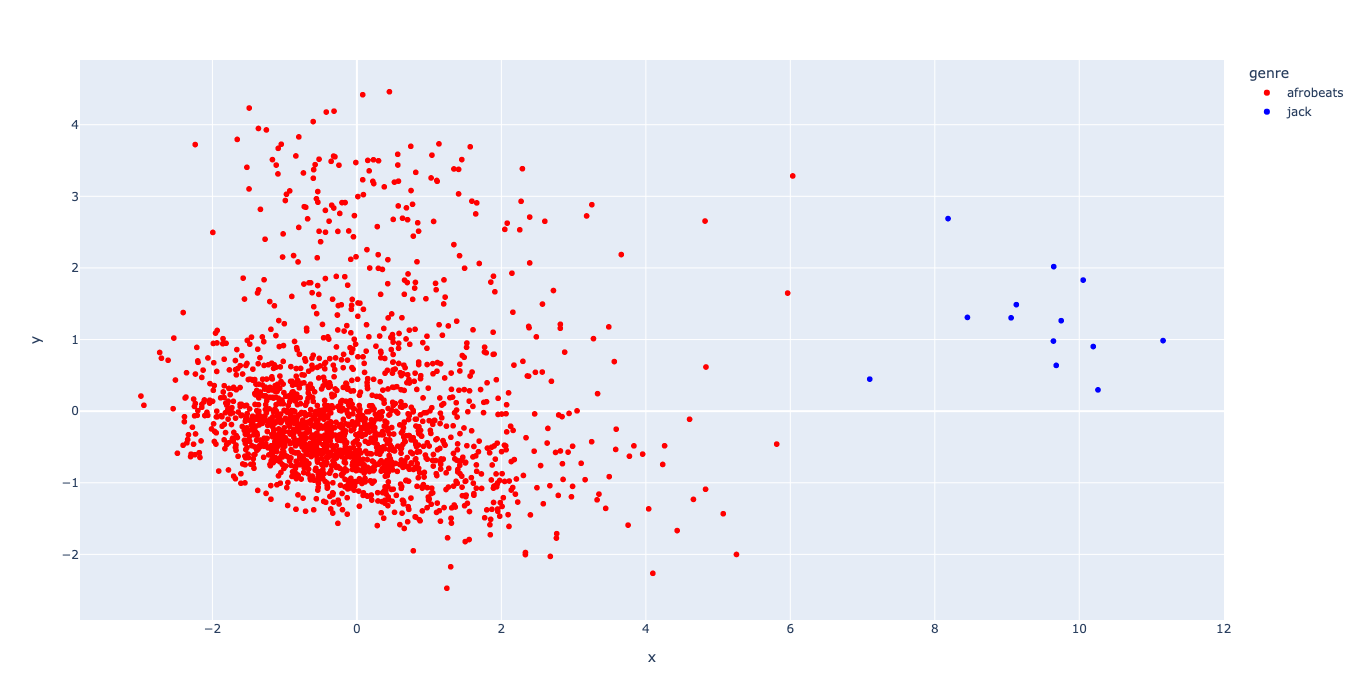

In [178]:
fig = px.scatter(pca_df, x='x', y='y',color='genre',
                 color_discrete_sequence=['red','blue'],
                 hover_name='track_name',width=1000, height=700)
fig.show()

#### Using TSNE for dimensionality reduction

In [179]:
pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('tsne', TSNE(n_components=2, verbose=False))
])
X_tnse = pipeline.fit_transform(X)


tsne_df = pd.DataFrame(columns=['x', 'y'], data=X_tnse)
tsne_df['genre'] = df['genre']
tsne_df['cluster'] = df['cluster']
tsne_df['track_name'] = df['track_name']

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [180]:
tsne_df.head()

,x,y,genre,cluster,track_name
0,-7.453203,-51.928120,afrobeats,1,Oleku (feat. Brymo)
1,-14.115933,17.092974,afrobeats,0,Move Back
2,27.674372,-15.134439,afrobeats,2,Pakurumo
3,16.951094,3.057381,afrobeats,2,The Matter (feat. Wizkid)
4,-0.216015,-38.212933,afrobeats,2,Slow Down (feat. Wiz Kid)


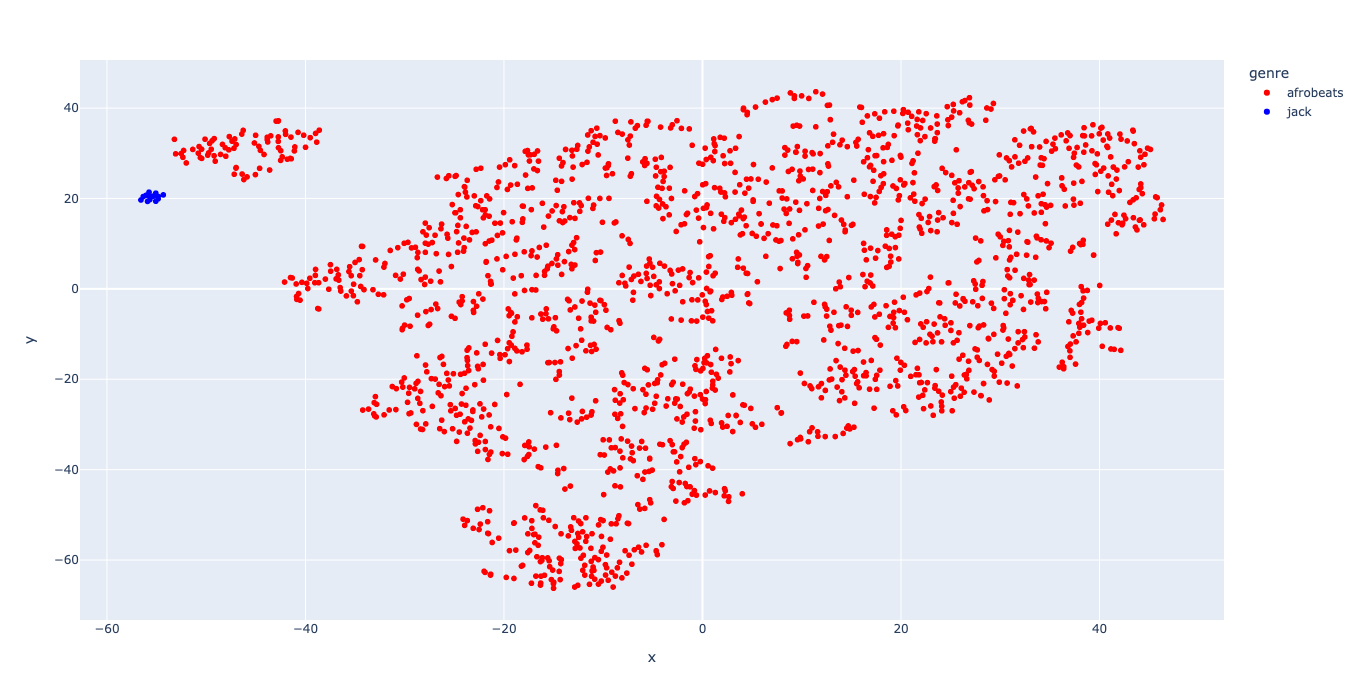

In [181]:
fig = px.scatter(tsne_df, x='x', y='y',color='genre',
                 color_discrete_sequence=['red','blue'],
                 hover_name='track_name',width=1000, height=700)
fig.show()

TSNE does a better job in maintaining the clusters while reducing the dimesnions

However, it take much longer than PCA and it doesn't give consistent results when run again

## Euclidean Distance measurement on the PCA data

By calculating the euclidean distance between all the points from the PCA data, I will create a datafame of tracks and their distance measurements 

In [212]:
dist = cdist(pca_df[['x','y']],pca_df[['x','y']])

In [213]:
dist

array([[ 0.        ,  2.56562145,  2.76548562, ..., 10.43215262,
         7.50298346,  9.97211128],
       [ 2.56562145,  0.        ,  0.73504011, ...,  9.88554976,
         6.76439383,  9.3531634 ],
       [ 2.76548562,  0.73504011,  0.        , ..., 10.60271422,
         7.47814674, 10.0666531 ],
       ...,
       [10.43215262,  9.88554976, 10.60271422, ...,  0.        ,
         3.12779616,  0.57657154],
       [ 7.50298346,  6.76439383,  7.47814674, ...,  3.12779616,
         0.        ,  2.58881322],
       [ 9.97211128,  9.3531634 , 10.0666531 , ...,  0.57657154,
         2.58881322,  0.        ]])

#### Create a dataframe of similarities


Converting the similarity array above into a dataframe

In [184]:
recommender_df = pd.DataFrame(dist,
                              columns=df['track_name'],
                             index=df['track_name']).drop(jack['track_name'])

In [185]:
recommender_df

track_name,Oleku (feat. Brymo),Move Back,Pakurumo,The Matter (feat. Wizkid),Slow Down (feat. Wiz Kid),Like to Party,Yahooze,Bumper To Bumper,Dami Duro,Gongo Aso,...,"Götterdämmerung, WWV 86D, Prologue: Siegfrieds Rheinfahrt","Piano Concerto No. 1 in D Minor, Op. 15: I. Maestoso - Poco più moderato",Symphony No. 1: IV. Stürmisch bewegt,"Symphony No.9 in E Minor, Op.95, B.178: 1. Adagio - Allegro molto","Symphony No.9 in E Minor, Op.95, B.178: 4. Allegro con fuoco","Mahler: Symphony No. 2 in C Minor ""Resurrection"": I. Allegro maestoso. Mit durchaus ernstem und feierlichem Ausdruck","Symphony No. 4 in C Minor, Op. 43: III. Largo - Allegro","Symphony No. 4 in E-Flat Major, WAB 104, ""Romantic"": III. Scherzo - Live",Messa da Requiem: 2a. Dies irae,"Der Freischütz, J. 277: Overture"
track_name,,,,,,,,,,,,,,,,,,,,,
Oleku (feat. Brymo),0.000000,2.565621,2.765486,2.541611,0.895264,1.568160,3.092597,2.642899,2.559543,3.193916,...,9.771987,9.875930,9.941797,8.649520,8.297972,11.376253,10.189954,10.432153,7.502983,9.972111
Move Back,2.565621,0.000000,0.735040,0.836962,2.054630,1.086166,1.004039,0.288595,3.083691,2.498167,...,9.514404,9.344726,9.485090,8.208081,8.284291,10.855266,9.876339,9.885550,6.764394,9.353163
Pakurumo,2.765486,0.735040,0.000000,0.278934,2.053175,1.555019,0.345697,0.447871,2.616998,1.823707,...,10.245568,10.064002,10.208259,8.934489,9.019295,11.572228,10.605244,10.602714,7.478147,10.066653
The Matter (feat. Wizkid),2.541611,0.836962,0.278934,0.000000,1.797159,1.448345,0.555261,0.583753,2.360381,1.661314,...,10.331796,10.176424,10.313890,9.033770,9.076883,11.688112,10.698129,10.718376,7.599053,10.187635
Slow Down (feat. Wiz Kid),0.895264,2.054630,2.053175,1.797159,0.000000,1.343911,2.350459,2.044831,1.813024,2.300927,...,10.289238,10.315185,10.403516,9.105199,8.869057,11.827856,10.694397,10.870590,7.855669,10.385595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
No Wahala,3.862679,1.298179,1.434054,1.706013,3.323746,2.345332,1.348629,1.282402,4.042418,3.094334,...,9.579463,9.270512,9.446727,8.218105,8.511285,10.750076,9.902829,9.788772,6.674866,9.231377
Question (feat. Don Jazzy),4.254650,1.767393,2.074036,2.333837,3.819947,2.690529,2.027894,1.838464,4.690904,3.782114,...,9.053764,8.699595,8.886495,7.680013,8.053635,10.164892,9.362332,9.209024,6.113768,8.646128
Peru,0.769238,3.219334,3.495195,3.284254,1.657673,2.157093,3.829416,3.331562,3.201615,3.945010,...,9.500847,9.682556,9.725799,8.447984,7.979734,11.163167,9.929660,10.236509,7.412537,9.803404


#### Create a function to predict top ten Afrobeats songs based on the playlist given

Testing out the similarity matrix

In [186]:
recommender_df['Symphony No. 4 in C Minor, Op. 43: III. Largo - Allegro'].sort_values(ascending=True)[0:20]

track_name
It's Okay to Cry                                   4.095240
Broken Parts                                       4.275461
Ojoro                                              4.821504
Still Think of You                                 5.299288
Questions                                          5.360790
Mixed Signals                                      5.785284
Do Not Disturb                                     5.955975
Hello Brother                                      5.988300
Missed Call                                        6.141360
LIKE IT                                            6.203821
Figure It Out                                      6.239607
Fejiro                                             6.364795
umoya                                              6.403979
'00 Nostalgia                                      6.565015
We Want to Know (Mo) Osibisa                       6.589603
Away                                               6.599391
Wait For You (feat. Oxlade)  

In [187]:
def recommend_afrobeats(df,track_names):
    top_df = pd.DataFrame(columns=df.columns)
    top_list = []
    
    #Get song from users playlis
    for track in track_names:
        
        
        for count in range(len(df)): 
            
            most_similar = recommender_df[track].sort_values(ascending=True).index[count]
            
            #check if song has already been recommended
            if most_similar in top_list:
                continue
            
            else:
                top_list.append(most_similar)
                break
                
        #create a dataframe of the recommended songs
        top_df = pd.concat([top_df, df[df['track_name']==most_similar]])
        
    return top_df

In [188]:
recommend_afrobeats(df,jack['track_name'])

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,cluster
842,5X99Res0qG01SxTy5puWFU,It's Okay to Cry,Yinka Bernie,{'external_urls': {'spotify': 'https://open.sp...,5TuVpSIsvh6lKoKLBsAxFL,33,['nigerian pop'],It's Okay to Cry,46,2020-02-21,...,173.972,audio_features,5X99Res0qG01SxTy5puWFU,spotify:track:5X99Res0qG01SxTy5puWFU,https://api.spotify.com/v1/tracks/5X99Res0qG01...,https://api.spotify.com/v1/audio-analysis/5X99...,213031.0,4.0,afrobeats,0
883,2MboJofvM4ERzJ9uPtRyaT,Ojoro,Oxlade,{'external_urls': {'spotify': 'https://open.sp...,3WTrdbZU99dgTtt3ZkyamT,60,"['afropop', 'nigerian pop']",Ojoro,19,2018-09-21,...,95.201,audio_features,2MboJofvM4ERzJ9uPtRyaT,spotify:track:2MboJofvM4ERzJ9uPtRyaT,https://api.spotify.com/v1/tracks/2MboJofvM4ER...,https://api.spotify.com/v1/audio-analysis/2Mbo...,213943.0,4.0,afrobeats,0
1363,7HM3WyOHG3Nm6Ck5aZaFKF,Ojoro,Terri,{'external_urls': {'spotify': 'https://open.sp...,6h3iqdnfBKV2jRhUJz0oto,54,['nigerian pop'],Ojoro,50,2020-04-30,...,109.978,audio_features,7HM3WyOHG3Nm6Ck5aZaFKF,spotify:track:7HM3WyOHG3Nm6Ck5aZaFKF,https://api.spotify.com/v1/tracks/7HM3WyOHG3Nm...,https://api.spotify.com/v1/audio-analysis/7HM3...,192000.0,4.0,afrobeats,2
908,3aOVK8gQWtE6syUPbLcz9B,Broken Parts,BenjiFlow,{'external_urls': {'spotify': 'https://open.sp...,3NRpcByltnHx7oZxWbg8Lt,49,"['indie r&b', 'nigerian pop', 'uk alternative ...",BENERGY,15,2020-03-13,...,176.007,audio_features,3aOVK8gQWtE6syUPbLcz9B,spotify:track:3aOVK8gQWtE6syUPbLcz9B,https://api.spotify.com/v1/tracks/3aOVK8gQWtE6...,https://api.spotify.com/v1/audio-analysis/3aOV...,182000.0,4.0,afrobeats,1
713,1KFSdaTOpqZXXQk1trlM8y,Still Think of You,melvitto,{'external_urls': {'spotify': 'https://open.sp...,4Xj0nxVO4r7PLEaw7LRiBa,65,['nigerian pop'],Summers,0,2019-11-04,...,190.781,audio_features,1KFSdaTOpqZXXQk1trlM8y,spotify:track:1KFSdaTOpqZXXQk1trlM8y,https://api.spotify.com/v1/tracks/1KFSdaTOpqZX...,https://api.spotify.com/v1/audio-analysis/1KFS...,223812.0,4.0,afrobeats,1
746,44mrWZc4dqE9zgqjKFmY00,Questions,Orinayo,{'external_urls': {'spotify': 'https://open.sp...,3lff4dAJpIXlirPPLTabaj,8,[],Questions,21,2020-04-25,...,128.382,audio_features,44mrWZc4dqE9zgqjKFmY00,spotify:track:44mrWZc4dqE9zgqjKFmY00,https://api.spotify.com/v1/tracks/44mrWZc4dqE9...,https://api.spotify.com/v1/audio-analysis/44mr...,225023.0,5.0,afrobeats,0
761,0D89NuvkYKIgKTnMGQwPUy,Mixed Signals,Fasina,{'external_urls': {'spotify': 'https://open.sp...,46A6IKsvzRN2Y6QHLkHvmw,36,"['alte', 'nigerian pop']",Mixed Signals,41,2019-12-06,...,126.604,audio_features,0D89NuvkYKIgKTnMGQwPUy,spotify:track:0D89NuvkYKIgKTnMGQwPUy,https://api.spotify.com/v1/tracks/0D89NuvkYKIg...,https://api.spotify.com/v1/audio-analysis/0D89...,222316.0,5.0,afrobeats,3
752,0xXqVYGvFCGFeFwPzwix3V,Hello Brother,Omah Lay,{'external_urls': {'spotify': 'https://open.sp...,5yOvAmpIR7hVxiS6Ls5DPO,73,['afro dancehall'],Hello Brother,46,2019-05-11,...,95.863,audio_features,0xXqVYGvFCGFeFwPzwix3V,spotify:track:0xXqVYGvFCGFeFwPzwix3V,https://api.spotify.com/v1/tracks/0xXqVYGvFCGF...,https://api.spotify.com/v1/audio-analysis/0xXq...,170031.0,4.0,afrobeats,0
992,5Mg5kfEzI7stnjNoXHyaUC,umoya,Blxckie,{'external_urls': {'spotify': 'https://open.sp...,4pQcWzOMSmmz5DK6TqO2FL,56,"['afro soul', 'south african pop', 'south afri...",4LUV,53,2022-02-18,...,169.942,audio_features,5Mg5kfEzI7stnjNoXHyaUC,spotify:track:5Mg5kfEzI7stnjNoXHyaUC,https://api.spotify.com/v1/tracks/5Mg5kfEzI7st...,https://api.spotify.com/v1/audio-analysis/5Mg5...,271018.0,4.0,afrobeats,1
751,6wj7t9nuC70oPgZ4H1J2hA,Do Not Disturb,Omah Lay,{'external_urls': {'spotify': 'https://open.sp...,5yOvAmpIR7hVxiS6Ls5DPO,73,['afro dancehall'],Do Not Disturb,52,2019-04-09,...,97.297,audio_features,6wj7t9nuC70oPgZ4H1J2hA,spotify:track:6wj7t9nuC70oPgZ4H1J2hA,https://api.spotify.com/v1/tracks/6wj7t9nuC70o...,https://api.spotify.co

#### Testing the recommender out with another playlist from a classmate

#### Import Ankita's Playlist

In [189]:
ankita= pd.read_csv('../data/ankita.csv')
ankita.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,068HSvCf5MbQfhV4qqaelg,"Haan Main Galat (From ""Love Aaj Kal"")",Pritam,{'external_urls': {'spotify': 'https://open.sp...,1wRPtKGflJrBx9BmLsSwlU,84,"['desi pop', 'filmi', 'indian instrumental', '...","Haan Main Galat (From ""Love Aaj Kal"")",62,2020-01-29,...,0.893,117.979,audio_features,068HSvCf5MbQfhV4qqaelg,spotify:track:068HSvCf5MbQfhV4qqaelg,https://api.spotify.com/v1/tracks/068HSvCf5MbQ...,https://api.spotify.com/v1/audio-analysis/068H...,218644,4,ankita
1,2aHz87L2Z4a0ZEQ7vMlH8z,Badal Pe Paon Hai,Salim–Sulaiman,{'external_urls': {'spotify': 'https://open.sp...,6ohaQzKaXrobAL8paLSaxq,64,"['desi pop', 'filmi', 'indian folk', 'modern b...",Chak De India,55,2007-08-01,...,0.869,104.999,audio_features,2aHz87L2Z4a0ZEQ7vMlH8z,spotify:track:2aHz87L2Z4a0ZEQ7vMlH8z,https://api.spotify.com/v1/tracks/2aHz87L2Z4a0...,https://api.spotify.com/v1/audio-analysis/2aHz...,243931,4,ankita


In [190]:
ankita.shape

(8, 29)

In [191]:
afrobeats = pd.read_csv('../data/afrobeats.csv')
afrobeats.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0mDRuZmReEm6DquPLJlcEm,Oleku (feat. Brymo),Ice Prince,{'external_urls': {'spotify': 'https://open.sp...,1sSt1DqqqFLkPwfrqafVyn,54,"['afro dancehall', 'afropop', 'azontobeats', '...",Oleku (feat. Brymo),49,2010-09-21,...,0.751,162.112,audio_features,0mDRuZmReEm6DquPLJlcEm,spotify:track:0mDRuZmReEm6DquPLJlcEm,https://api.spotify.com/v1/tracks/0mDRuZmReEm6...,https://api.spotify.com/v1/audio-analysis/0mDR...,291364.0,5.0,afrobeats
1,1tvi8tv0eykhNcV1WtaIqO,Move Back,5five,{'external_urls': {'spotify': 'https://open.sp...,37zb1JQnDV9dRLatrASEj1,29,"['afro dancehall', 'azonto', 'hiplife']",Move Back,43,2011-04-08,...,0.793,125.032,audio_features,1tvi8tv0eykhNcV1WtaIqO,spotify:track:1tvi8tv0eykhNcV1WtaIqO,https://api.spotify.com/v1/tracks/1tvi8tv0eykh...,https://api.spotify.com/v1/audio-analysis/1tvi...,237107.0,4.0,afrobeats


In [192]:
afrobeats.shape

(1874, 29)

In [193]:
df_1 = pd.concat([afrobeats, ankita])

In [194]:
df_1.reset_index(inplace=True, drop=True)

In [195]:
df_1.head()

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0mDRuZmReEm6DquPLJlcEm,Oleku (feat. Brymo),Ice Prince,{'external_urls': {'spotify': 'https://open.sp...,1sSt1DqqqFLkPwfrqafVyn,54,"['afro dancehall', 'afropop', 'azontobeats', '...",Oleku (feat. Brymo),49,2010-09-21,...,0.751,162.112,audio_features,0mDRuZmReEm6DquPLJlcEm,spotify:track:0mDRuZmReEm6DquPLJlcEm,https://api.spotify.com/v1/tracks/0mDRuZmReEm6...,https://api.spotify.com/v1/audio-analysis/0mDR...,291364.0,5.0,afrobeats
1,1tvi8tv0eykhNcV1WtaIqO,Move Back,5five,{'external_urls': {'spotify': 'https://open.sp...,37zb1JQnDV9dRLatrASEj1,29,"['afro dancehall', 'azonto', 'hiplife']",Move Back,43,2011-04-08,...,0.793,125.032,audio_features,1tvi8tv0eykhNcV1WtaIqO,spotify:track:1tvi8tv0eykhNcV1WtaIqO,https://api.spotify.com/v1/tracks/1tvi8tv0eykh...,https://api.spotify.com/v1/audio-analysis/1tvi...,237107.0,4.0,afrobeats
2,5YgyvTZmdkIfFOnj8ri8mZ,Pakurumo,WizKid,{'external_urls': {'spotify': 'https://open.sp...,3tVQdUvClmAT7URs9V3rsp,80,"['afro dancehall', 'afropop', 'azonto', 'niger...",Superstar,47,2011-07-01,...,0.967,119.990,audio_features,5YgyvTZmdkIfFOnj8ri8mZ,spotify:track:5YgyvTZmdkIfFOnj8ri8mZ,https://api.spotify.com/v1/tracks/5YgyvTZmdkIf...,https://api.spotify.com/v1/audio-analysis/5Ygy...,212006.0,4.0,afrobeats
3,2cWdhA4ZDBvYuHRKKIPT3k,The Matter (feat. Wizkid),Maleek Berry,{'external_urls': {'spotify': 'https://open.sp...,520qA5VGL9iI0SbmEnTVNg,60,"['afro dancehall', 'afropop', 'azontobeats', '...",The Matter (feat. Wizkid),47,2013-03-10,...,0.808,103.070,audio_features,2cWdhA4ZDBvYuHRKKIPT3k,spotify:track:2cWdhA4ZDBvYuHRKKIPT3k,https://api.spotify.com/v1/tracks/2cWdhA4ZDBvY...,https://api.spotify.com/v1/audio-analysis/2cWd...,198058.0,4.0,afrobeats
4,4voOsb8qpJ569JaMiGAyrl,Slow Down (feat. Wiz Kid),R2Bees,{'external_urls': {'spotify': 'https://open.sp...,0LFsP7WPfu5inz9a1amcE4,51,"['afro dancehall', 'afropop', 'azonto', 'azont...",Refuse to Be Broke: Da Revolution 2,51,2014,...,0.704,135.550,audio_features,4voOsb8qpJ569JaMiGAyrl,spotify:track:4voOsb8qpJ569JaMiGAyrl,https://api.spotify.com/v1/tracks/4voOsb8qpJ56...,https://api.spotify.com/v1/audio-analysis/4voO...,261547.0,5.0,afrobeats


#### Using PCA reduce the features into 2 dimentions for better visualization

In [196]:
X_1 = df_1[features]

In [197]:
pipeline_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

In [198]:
pipeline_pca.fit(X_1)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

In [199]:
pca_df_1=pd.DataFrame(pipeline_pca.transform(X_1), columns=['x','y'])

In [200]:
pca_df_1['genre'] = df_1['genre']
pca_df_1['track_name'] = df_1['track_name']

#### Using Plotly to display the data interactively

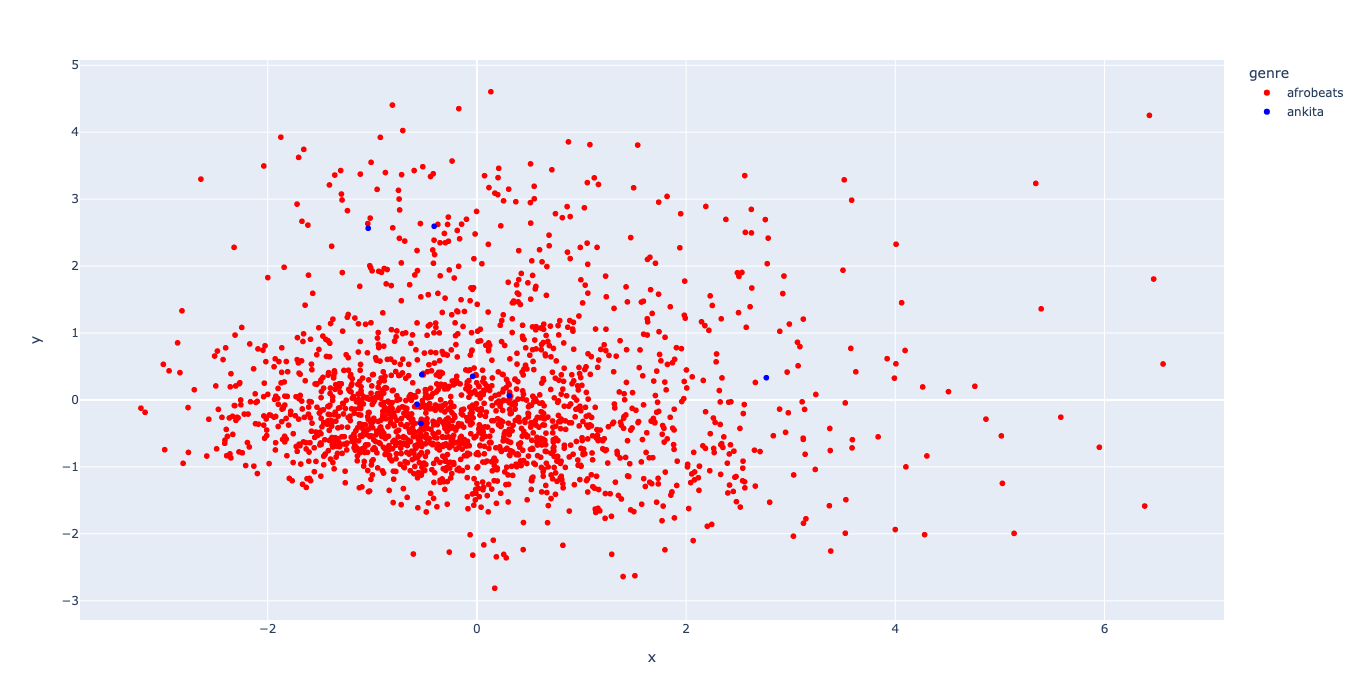

In [201]:
fig = px.scatter(pca_df_1, x='x', y='y',color='genre',
                 color_discrete_sequence=['red','blue'],
                 hover_name='track_name',width=1000, height=700)
fig.show()

In [204]:
dist = cdist(pca_df_1[['x','y']],pca_df_1[['x','y']])

#### Create a dataframe of similarities


In [210]:
recommender_df_1 = pd.DataFrame(dist,
                              columns=df_1['track_name'],
                             index=df_1['track_name']).drop(ankita['track_name'])

#### Get recommendations

In [211]:
recommend_afrobeats(df_1,ankita['track_name'])

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
1759,2LLdpfd55EgqnkKiAPcCtw,Ololo,Stonebwoy,{'external_urls': {'spotify': 'https://open.sp...,2ayt5jDUuTCpoTG7sHSvuq,53,"['afro dancehall', 'dancehall', 'ghanaian pop'...",Ololo,0,2019-09-13,...,0.889,102.966,audio_features,2LLdpfd55EgqnkKiAPcCtw,spotify:track:2LLdpfd55EgqnkKiAPcCtw,https://api.spotify.com/v1/tracks/2LLdpfd55Egq...,https://api.spotify.com/v1/audio-analysis/2LLd...,163331.0,4.0,afrobeats
1153,4V6wKwyGIykKCatXtky1VC,My Life,Dj Manuel,{'external_urls': {'spotify': 'https://open.sp...,3kpSioYUJejgUYIUiS78LR,12,['nigerian pop'],My Life,0,2021-01-15,...,0.733,92.581,audio_features,4V6wKwyGIykKCatXtky1VC,spotify:track:4V6wKwyGIykKCatXtky1VC,https://api.spotify.com/v1/tracks/4V6wKwyGIykK...,https://api.spotify.com/v1/audio-analysis/4V6w...,216774.0,4.0,afrobeats
1255,23uSSO6CvkSbjCDUiYUh77,My Life,DJ Sly,{'external_urls': {'spotify': 'https://open.sp...,5v9Layw1lp9IkuTEGsNjBM,1,[],My Life,4,2020-10-23,...,0.752,103.005,audio_features,23uSSO6CvkSbjCDUiYUh77,spotify:track:23uSSO6CvkSbjCDUiYUh77,https://api.spotify.com/v1/tracks/23uSSO6CvkSb...,https://api.spotify.com/v1/audio-analysis/23uS...,186358.0,4.0,afrobeats
1295,1OV9hRdiyYDuRayvO9QQzT,Overdose Remix,Dunnie,{'external_urls': {'spotify': 'https://open.sp...,5q1uxBdFXCDZDdNOw2rzD2,28,[],Overdose Remix,0,2020-09-18,...,0.486,103.029,audio_features,1OV9hRdiyYDuRayvO9QQzT,spotify:track:1OV9hRdiyYDuRayvO9QQzT,https://api.spotify.com/v1/tracks/1OV9hRdiyYDu...,https://api.spotify.com/v1/audio-analysis/1OV9...,177087.0,4.0,afrobeats
286,0whUOKHJ2FK9InBanfwEci,Angela,Kuami Eugene,{'external_urls': {'spotify': 'https://open.sp...,0GGKrcPOlBkmBzQDf2Ogkl,57,"['asakaa', 'azontobeats']",Angela,44,2017-09-06,...,0.92,200.075,audio_features,0whUOKHJ2FK9InBanfwEci,spotify:track:0whUOKHJ2FK9InBanfwEci,https://api.spotify.com/v1/tracks/0whUOKHJ2FK9...,https://api.spotify.com/v1/audio-analysis/0whU...,187298.0,4.0,afrobeats
945,4sh6VEmaZBqVN4XEvnev86,Non Living Thing (feat. Oxlade),Sarkodie,{'external_urls': {'spotify': 'https://open.sp...,01DTVE3KmoPogPZaOvMqO8,57,"['afro dancehall', 'afropop', 'azonto', 'azont...",No Pressure,0,2021-07-30,...,0.689,106.932,audio_features,4sh6VEmaZBqVN4XEvnev86,spotify:track:4sh6VEmaZBqVN4XEvnev86,https://api.spotify.com/v1/tracks/4sh6VEmaZBqV...,https://api.spotify.com/v1/audio-analysis/4sh6...,229346.0,4.0,afrobeats
193,3k9Y1OBtIdPQNqbKILvJcD,IDG,Aṣa,{'external_urls': {'spotify': 'https://open.sp...,0upXUo04k4k8bGVSkmgrSc,58,"['alte', 'neo soul', 'nigerian pop', 'pop soul']",V,64,2022-02-25,...,0.646,197.84,audio_features,3k9Y1OBtIdPQNqbKILvJcD,spotify:track:3k9Y1OBtIdPQNqbKILvJcD,https://api.spotify.com/v1/tracks/3k9Y1OBtIdPQ...,https://api.spotify.com/v1/audio-analysis/3k9Y...,187500.0,4.0,afrobeats
1141,1tRdrgjBQB6qVgxpbcW9UV,As Friends,Gabzy,{'external_urls': {'spotify': 'https://open.sp...,2sEUjEtnqBphiYquoNfV62,63,['nigerian pop'],Malone,55,2020-12-18,...,0.649,96.241,audio_features,1tRdrgjBQB6qVgxpbcW9UV,spotify:track:1tRdrgjBQB6qVgxpbcW9UV,https://api.spotify.com/v1/tracks/1tRdrgjBQB6q...,https://api.spotify.com/v1/audio-analysis/1tRd...,212284.0,4.0,afrobeats
1799,680lETWgYaHdQt8847XsvV,Who Dey Eat,Shaker,{'external_urls': {'spotify': 'https://open.sp...,5I1G1MSxXh3zrZsVZCPzZj,11,[],Who Dey Eat,22,2019-08-28,...,0.964,140.009,audio_features,680lETWgYaHdQt8847XsvV,spotify:track:680lETWgYaHdQt8847XsvV,https://api.spotify.com/v1/tracks/680lETWgYaHd...,https://api.spotify.com/v1/audio-analysis/680l...,246857.0,4.0,afrobeats
